<a href="https://colab.research.google.com/github/leclercsimon74/Infection_Prediction_CPV/blob/main/Prediction_of_infection_by_ML_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First prepare the dataset!
It should consist of only the nucleus of interest, one by image. The ImageJ macro in the same folder than this book can do it semi auto. The image should be 100x100 pixels with one channel (DNA).
Upldoad the dataset to the drive, then change the directory to test and the result name in the book

In [ ]:
#connect the drive with the data to train/analyse
from google.colab import drive
drive.mount('/content/gdrive')


#Import tensorflow and check for GPU access
import tensorflow as tf
print('TensorFlow version:'+tf.__version__)
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.')
  print('Did you change your runtime ?')
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')

Mounted at /content/gdrive
TensorFlow version:2.15.0
You have GPU access


In [ ]:
import os

#change the working directory to work in the local drive directory
ori_path = os.getcwd()+os.sep+'gdrive'+os.sep+'MyDrive'+os.sep+'Colab Notebooks'+os.sep
os.chdir(ori_path)
print(ori_path)

/content/gdrive/MyDrive/Colab Notebooks/


In [ ]:
to_predict_path = ori_path+os.sep+'Prediction'+os.sep+'Randomly imaged repeat 3'

In [ ]:
#excel support
!pip install -q xlrd
!pip install -q xlwt
#global imports
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import CSVLogger
import tifffile
from skimage.transform import resize



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
#function used

#Machine learning part
class MyCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, freq=5, directory=os.getcwd()):
        """Save the weight of the model at specified interval"""
        super().__init__()
        self.freq = freq
        self.directory = directory

    def on_epoch_begin(self, epoch, logs=None):
        if self.freq > 0 and epoch % self.freq == 0:
            filepath = self.directory +os.sep+"model_weight-"+str(epoch)
            self.model.save_weights(filepath)

    def on_train_end(self, logs=None):
        self.model.save_weights(self.directory+os.sep+"model_weight-last")


def make_model():
    """simple model for discrimination. Three conv2D with different filters size
    to detect small features of the image.
    The image input sould be 100 by 100 pixel in one color (1 channel).
    Return the model"""
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Input(shape=(100,100,1)))
    cnn.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'))
    cnn.add(tf.keras.layers.MaxPooling2D(2))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
    cnn.add(tf.keras.layers.MaxPooling2D(2))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
    cnn.add(tf.keras.layers.MaxPooling2D(2))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dropout(0.2))
    cnn.add(tf.keras.layers.Dense(24, activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    cnn.add(tf.keras.layers.Dropout(0.3))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.Dense(3, activation='softmax'))
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
                metrics=['accuracy'])

    return cnn

def augment_patches(patches):
    #logistic function that augment the data by rotation and flip (*8)
    augmented = np.concatenate((patches,
                                np.rot90(patches, k=1, axes=(1, 2)),
                                np.rot90(patches, k=2, axes=(1, 2)),
                                np.rot90(patches, k=3, axes=(1, 2))))

    augmented = np.concatenate((augmented, np.flip(augmented, axis=-2)))
    return augmented

def found_img(path, extension='.tif'):
    #logistic function to found all tif/extension file
    imgs = [f for f in os.listdir(path) if f.endswith(extension)]
    imgs_path = [path+os.sep+f for f in imgs]
    return imgs_path

def get_data(path, name):
    #get the images, augment them and adjust their dimension so to fit for ML
    img_paths = found_img(path, extension='.png')
    imgs = []
    names = []
    for path in img_paths:
        img = Image.open(path).convert('L')
        img = np.array(img, dtype=np.float32)
        img /= 255
        img = img[..., np.newaxis]
        img_a = augment_patches(img[np.newaxis,...])
        for img in img_a:
            names.append(name)
            imgs.append(img[..., np.newaxis])

    return np.array(imgs), names

def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

In [ ]:
#load an existing model
model_name = found_img(os.getcwd(), extension='.h5')
weight = [x for x in os.listdir(os.getcwd()) if 'model_weight-' in x]
selected_name = 'model1.1_93.74.h5'
if selected_name != '':
    cnn = tf.keras.models.load_model(selected_name)
    print('Load the named model: '+selected_name)
elif len(model_name) != 0: #from a clean saved model
    model_name = sorted_nicely(model_name)
    model_name = model_name[-1] #highest score
    cnn = tf.keras.models.load_model(model_name)
    print('Load the full model: '+model_name)
elif len(weight) != 0: #from a security saved, the weight WARNING, assuming the SAME model!!
    last = [x for x in weight if 'model_weight-last' in x]
    if len(last) != 0:
      weight = sorted_nicely(weight)
      weight = weight[-1]
    else:
      weight = last
    cnn = make_model()
    cnn.load_weights(weight)
else:
    print('No model present in the folder')

Load the named model: model1.1_93.74.h5


2/2 [==============================] - 0s 6ms/step


<ipython-input-11-d333049f6d4f>:31: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(to_predict_path+os.sep+'Results.xls') #as an old 1998 excel file


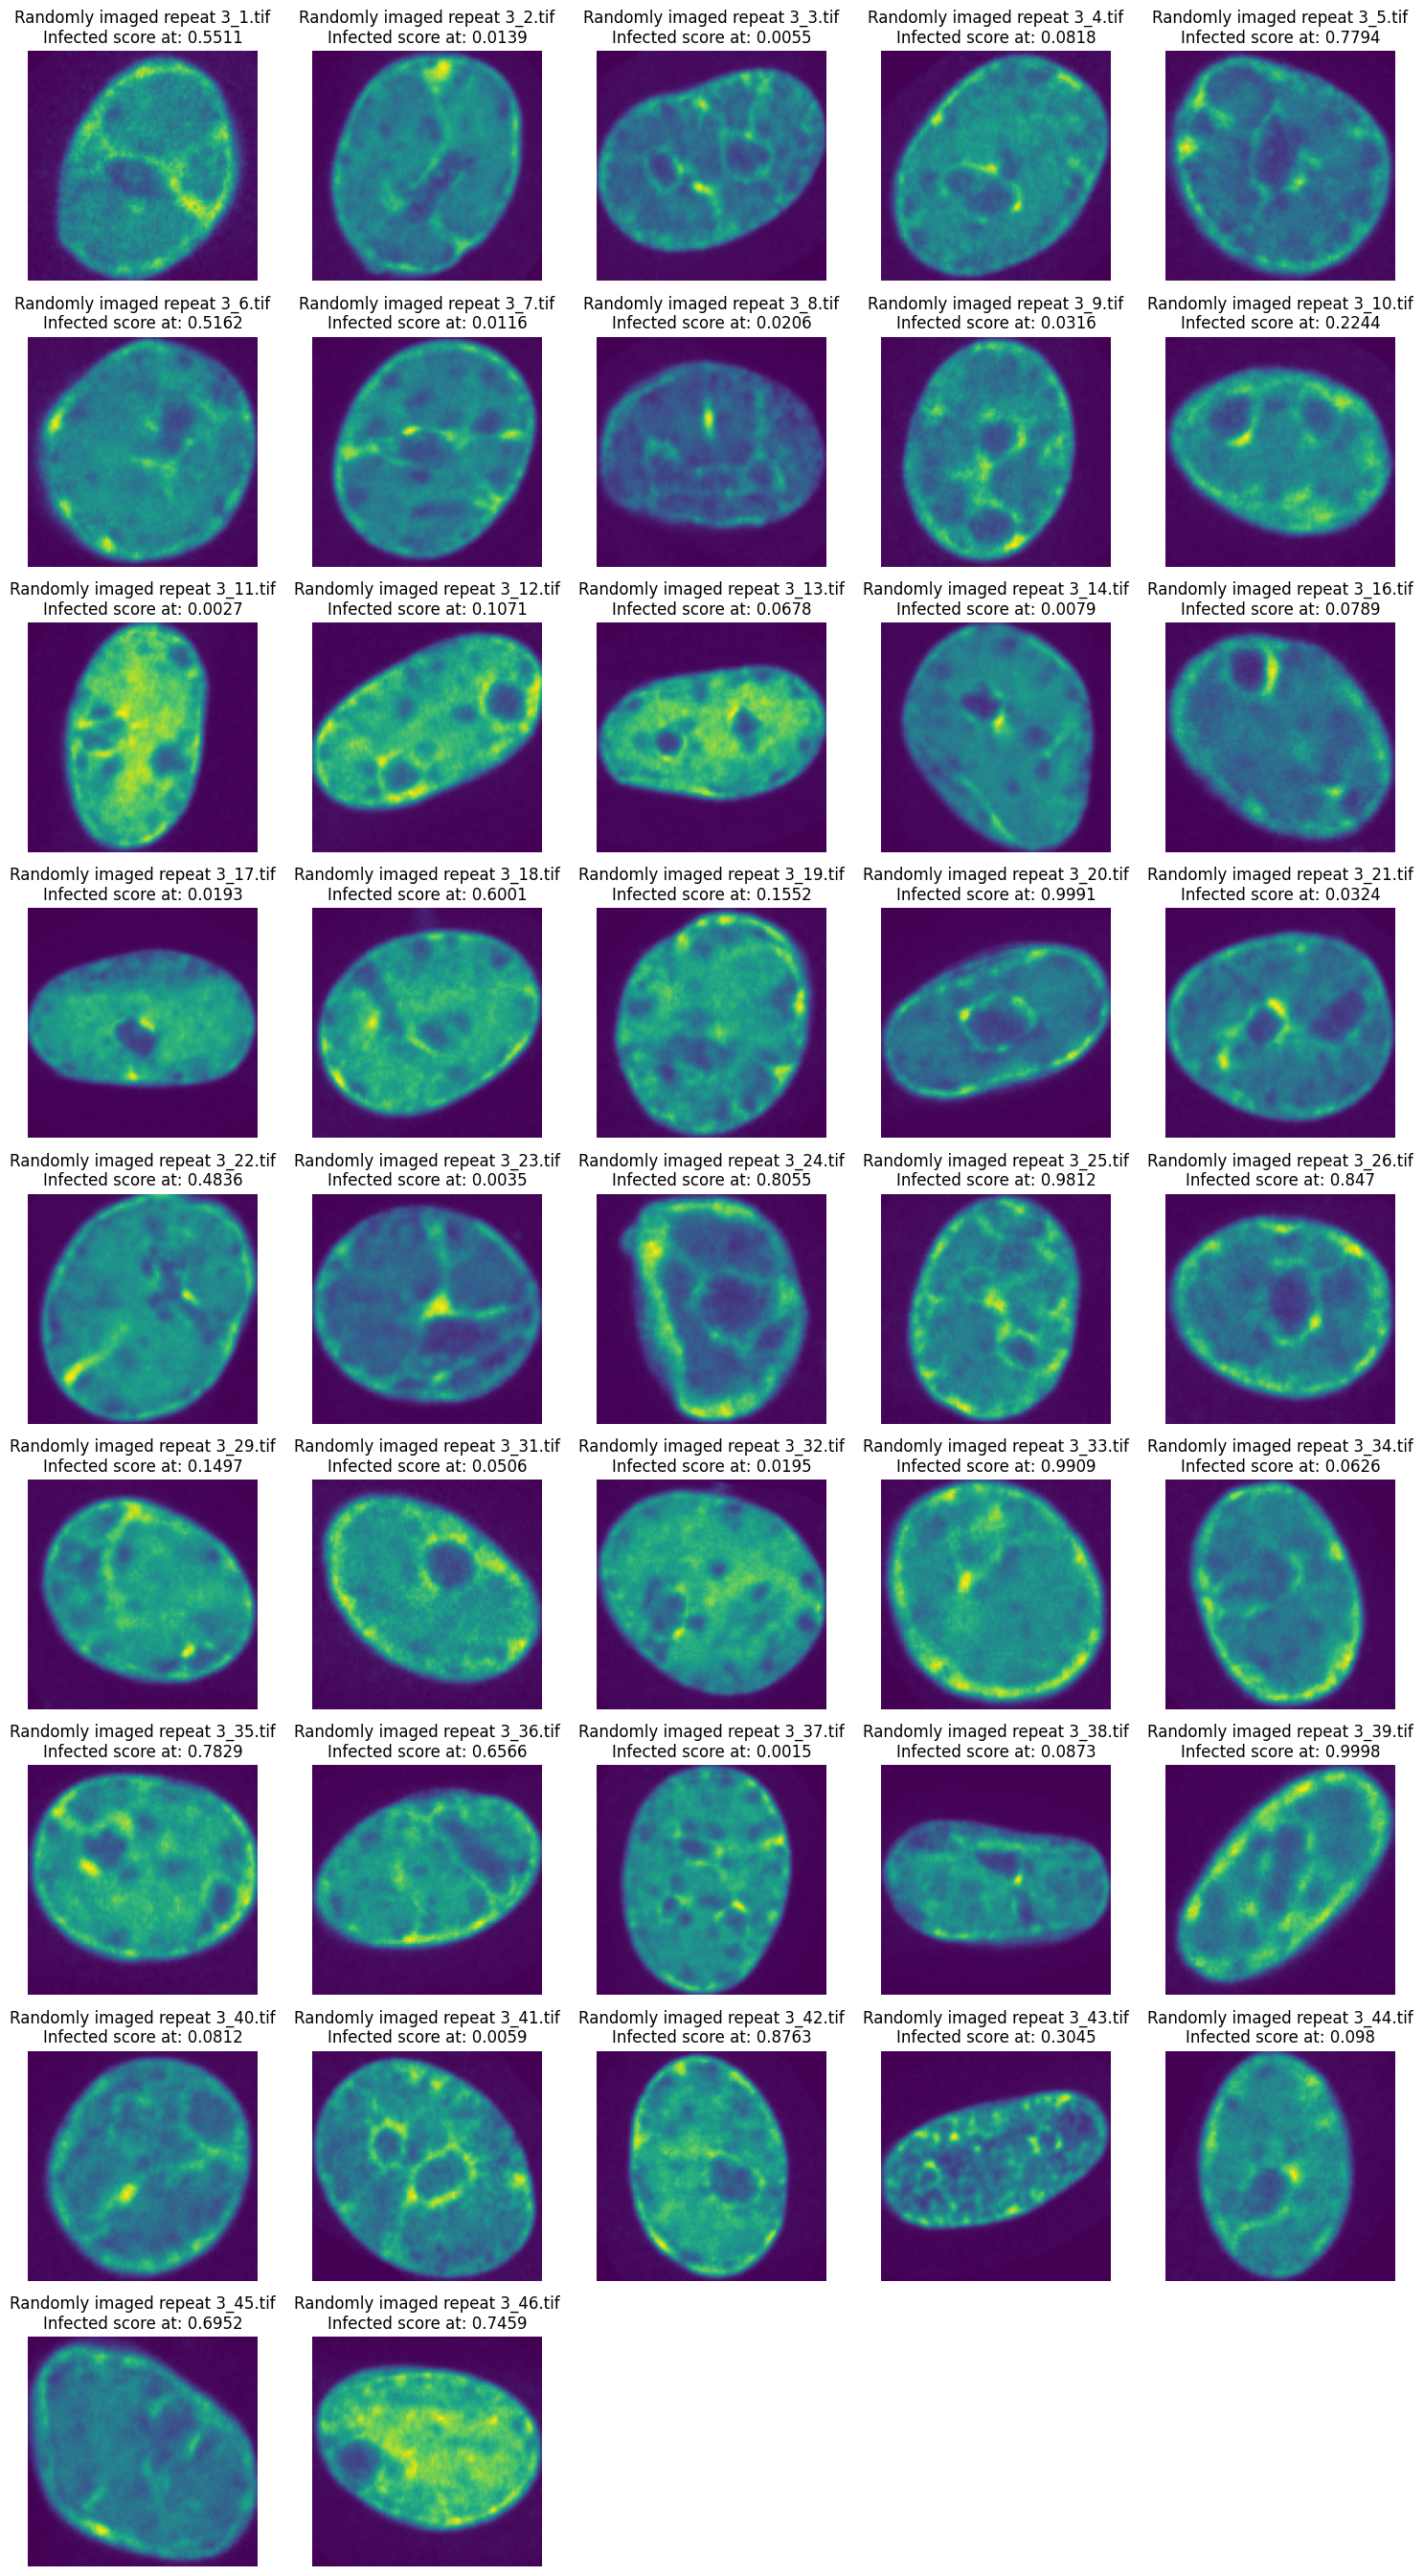

In [ ]:
#predict all images in a folder
def get_data(path):
    #small function to grab the images and prepare them in a similar way to the training dataset
    img_paths = os.listdir(path)
    img_paths = sorted_nicely(img_paths)
    imgs = []
    names = []
    for p in img_paths:
        #img = Image.open(path+os.sep+p).convert('L')
        img = tifffile.imread(path+os.sep+p)
        img = np.array(img, dtype=np.float32)
        img = resize(img, (100,100))
        img /= 255
        imgs.append(img)
        names.append(p)

    return imgs, names


img_list, img_name = get_data(to_predict_path)

img_arr = np.array(img_list)
img_arr = img_arr[..., np.newaxis] #need a channel dimension
prediction = cnn.predict(img_arr) #prediction here

# Data organization and saving
df = pd.DataFrame(data=img_name, columns=['Name'])
df['Infected score'] = prediction[:,0]
df['Noninfected score'] = prediction[:,1]
df['Out score'] = prediction[:,2]
df.to_excel(to_predict_path+os.sep+'Results.xls') #as an old 1998 excel file


#figure, showing ALL images. Be sure to avoid predict thoushands at the same time!
nrows = len(df)//5 + 1
fig, ax = plt.subplots(figsize=(15, nrows*3) , nrows=nrows, ncols=5)

im = 0
for j, row in enumerate(ax):
    for k, col in enumerate(row):
        if im < len(df):
            col.imshow(img_list[im])
            score = 'Infected score at: '
            score = score+str(round(prediction[im][0], 4))
            col.set_title(img_name[im].replace('.png', '')+'\n'+score)

        col.set_axis_off()
        im += 1

plt.tight_layout()
plt.savefig(to_predict_path+os.sep+'Prediction_results.png', dpi=150)
plt.show()